In [68]:
# Import relevant packages
import pandas as pd
import nltk

import re
import string

#Importing sentiment lexicons
from nltk.sentiment import SentimentIntensityAnalyzer #VADER
from afinn import Afinn #AFINN
from nltk.corpus import stopwords



from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer # Porter is used below. This is an alternative, harsher stemmer. 
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet

from collections import defaultdict

#Import packages for visualizations



#Import os and select directory
import os

os.chdir(r"/Users/alex/Desktop/dataset")

In [66]:
pip install afinn

Note: you may need to restart the kernel to use updated packages.


In [59]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alex/nltk_data...


True

In [34]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /Users/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/alex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/alex/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/alex/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# ASDS2 Exercises

## April 26: Sentiment analysis

In this exercise, you will be replicating part of the sentiment analysis from the paper 'Tones from a Narrowing Race: Polling and Online Political Communication during the 2014 Scottish Referendum Campaign' by Evelyne Brie and Yannick Dufresne (2018). 

More specifically, you will be checking their results by implementing sentiment analysis with two alternative sentiment lexicons: the AFINN and VADER (Valence Aware Dictionary and sEntiment Reasoner) lexicons. 

### 1: Importing aggregated data

The file 'PollData-ForRegression.csv' contains the aggregated data and sentiment results as used in the paper. The variable 'scoreDayAvg' shows their computed sentiment scores. Import this data for comparison. 

1. Import 'PollData-ForRegression.csv'
2. Convert 'date' from a string type to datetime type variable

In [5]:
dfreg = pd.read_csv('PollData-ForRegression.csv')

### 2: Preprocessing raw tweet data

The dataset 'Tones_Tweets.csv' contains the raw tweets that we will be working with.

1. Load in the dataset 'Tones_Tweets.csv', containing tweets from Yes Scotland and Better Together
2. Convert 'date' from a string type to datetime type variable
3. Isolate a subset of the data corresponding to the period used in the article, i.e. 15/06/2014 - 17/09/2014

In [8]:
df = pd.read_csv('Tones_Tweets.csv', encoding='latin-1')

In [14]:
#Converting date 
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

In [20]:
#Creating the subset
df = df[(df['date']>='2014-05-15') & (df['date'] <='2014-09-17')]

In [21]:
#Shape of the 15/06/2014 - 17/09/2014 subset of the dataset

print(df.shape)
df.head()

(4348, 3)


,text,date,campaign
135,With a Yes vote we can protect our valued NHS ...,2014-09-17,Yes Scotland
136,The independence debate has seen democracy flo...,2014-09-17,Yes Scotland
137,There's only ONE way to guarantee Scotland get...,2014-09-17,Yes Scotland
138,Got #indyref questions? Get you answers here: ...,2014-09-17,Yes Scotland
139,There's only ONE way to guarantee Scotland get...,2014-09-17,Yes Scotland


### 2: Preprocessing continued

Next, use the steps from the lecture last week to preprocess the data as you see fit. Although mentioned below, not all preprocessing will make a difference in sentiment analysis, as e.g. punctuation will not have a positive or negative valence, and you can therefore get by with fewer preprocessing steps than suggested. 

Suggestions for preprocessing: 

4. Lowercase all words
5. Remove 'RT' and 'via'
6. Remove all mentions (@some_one)
7. Remove common words used in the campaigns that may add noise to the sentiment analysis, such as 'better', 'together' 'darling', 'yes', 'no' and combinations like 'bettertogether'
8. Remove numbers, punctuation, separators, and urls
9. Lemmatize
10. Remove stopwords

In [49]:
#remove #
df['text'] = df['text'].map(lambda x: re.sub(r'#', '', x))

In [55]:
#Removing urls?
df['text'] = df['text'].map(lambda x: re.sub(r'\b\w*www\w*\b', '', x))
df['text'] = df['text'].map(lambda x: re.sub(r'\b\w*.com\w*\b', '', x))
df['text'] = df['text'].map(lambda x: re.sub(r'\b\w*http\w*\b', '', x))
df['text'] = df['text'].map(lambda x: re.sub(r'\b\w*tco\w*\b', '', x))
df['text'] = df['text'].map(lambda x: re.sub(r'\b\w*www\w*\b', '', x))
df['text'] = df['text'].map(lambda x: re.sub(r'\/+\w*\b', '', x))


In [51]:
#Applying lambda (resub) to all rows to remove words form the campaigns
df['text'] = df['text'].map(lambda x: re.sub(r'\b\w*better\w*\b', '', x))
df['text'] = df['text'].map(lambda x: re.sub(r'\b\w*together\w*\b', '', x))
df['text'] = df['text'].map(lambda x: re.sub(r'\b\w*darling\w*\b', '', x))
df['text'] = df['text'].map(lambda x: re.sub(r'\b\w*yes\w*\b', '', x))
df['text'] = df['text'].map(lambda x: re.sub(r'\b\w*no\w*\b', '', x))
df['text'] = df['text'].map(lambda x: re.sub(r'\b\w*\/\w*\b', '', x))

In [37]:
#Applying lambda (resub) to all rows to remove rt
df['text'] = df['text'].map(lambda x: re.sub(r'rt :', '', x))

In [27]:
#Applying lambda (resub) to all rows to remove handles
df['text'] = df['text'].map(lambda x: re.sub(r'@+\b\w+', '', x))

#Applying lambda (resub) to all rows to remove punctuations
df['text'] = df['text'].map(lambda x: re.sub(r'[\.\!\=\,\-\_\?\']', '', x))

#Lowercase all tweets
df['text'] = df['text'].str.lower()

#Remove extra whitespaces
df['text'] = df['text'].map(lambda x: re.sub(r' + ', ' ', x))

#Remove default stopwords
stop = stopwords.words('english') 

df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

<ipython-input-27-c4243b24956d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].map(lambda x: re.sub(r'@+\b\w+', '', x))
<ipython-input-27-c4243b24956d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].map(lambda x: re.sub(r'[\.\!\=\,\-\_\?\']', '', x))
<ipython-input-27-c4243b24956d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [63]:
df['vader'][153]

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [35]:
#Lemmatize words 

def lemmatize(sent):
    
    #First, the nltk wordnet lemmatizer needs the part-of-speech (POS) tag to correctly lemmatize
    #NLTK has a POS-tagger, but the format does not match POS-tags in wordnet's lemmatizer. 
    #The mapping dictionary below fixes that.
    
    tag_map = defaultdict(lambda : wordnet.NOUN)  #If nothing else is specified, use noun tag
    tag_map['J'] = wordnet.ADJ
    tag_map['V'] = wordnet.VERB
    tag_map['R'] = wordnet.ADV    
    
    lemmatizer = WordNetLemmatizer()        #Creating lemmatizer.
    
    sent = word_tokenize(sent)              #Tokenizing, as lemmatizer only takes tokenized sentences
    sent_lemmatized = []                    #Empty list to save lemmatized sentence

    for word, tag in pos_tag(sent):
        lemma = lemmatizer.lemmatize(word, tag_map[tag[0]])  #Where the magic happens
        sent_lemmatized.append(lemma)
    
    return ' '.join(sent_lemmatized)

df['text'] = df['text'].apply(lambda x: lemmatize(x))

### 3: Sentiment analysis 

Calculate a sentiment score for each tweet using the VADER and AFINN lexicons for sentiment analysis. 

The VADER lexicon is the sentiment analyzer integrated in NLTK and can be imported using `from nltk.sentiment import SentimentIntensityAnalyzer`. VADER summarizes the sentiment score for each sentence in a normalized variable called 'compound', scoring sentences between -1 (most negative) to 1 (most positive). Read about the VADER sentiment scoring here: https://github.com/cjhutto/vaderSentiment#about-the-scoring.

The AFINN lexicon can be imported using `from afinn import Afinn`. AFINN ranks words on a scale from -5 to 5 and computes the resulting sum for full sentences. Sentences with negative score are categorized as negative, sentences with a score of 0 are neutral, and sentences with a positive score are positive. 


##### VADER (Valence Aware Dictionary and sEntiment Reasoner) 

In [57]:
#Importing the sentiment analyzer
from afinn import Afinn

#YOUR CODE HERE


#Computing score for a random test sentence 
test_preprocessed = df['text_preprocessed'][976] #Find the preprocessed tweet with index 976 the way you have saved it to check your result against mine below
test_original = df['text'][976]

score = #YOUR CODE HERE

print(test_original, '\n\n', test_preprocessed, '\n\n', score)


SyntaxError: invalid syntax (<ipython-input-57-d6f6f7927357>, line 10)

In [69]:
#Running sentiment analysis with vader lexicon on all tweets
analyzer = SentimentIntensityAnalyzer()

df['vader'] = df['text'].apply(lambda x: analyzer.polarity_scores(x))

##### AFINN

In [13]:
#Importing the sentiment analyzer

#YOUR CODE HERE



#Computing score for the same test sentence 

score = #YOUR CODE HERE

print(test_original, '\n\n', test_preprocessed, '\n\n', score)


Yes gives us the opportunity to massively increase childcare  #indyref #voteYes #Scotland http://t.co/a6cLBeQNaw 

 give u opportunity massively increase childcare indyref voteyes scotland 

 3.0


In [72]:
#Running sentiment analysis with afinn lexicon on all tweets
afinn = Afinn()

df['afinn'] = df['text'].apply(lambda x: afinn.score(x))

##### MEAN SENTIMENT SCORE PER CAMPAIGN

Use Panda's `groupby` function to calculate the mean sentiment score per campaign for each lexicon (VADER and AFINN) and compare with the mean sentiment score in PollData-ForRegression.csv. Which campaign is on average more positive? Is this consistent with the results in the paper?

In [79]:
df.groupby('campaign').mean()

,afinn
campaign,
Better Together,1.148754
Yes Scotland,1.387700


##### CORRELATIONS

Do the authors' sentiment scores correlate with the sentiment scores calculated by us via the AFINN and VADER lexicons?

Correlate the authors' calculated sentiment scores with the sentiment scores computed with the AFINN and VADER lexicons per campaign. Visualize these correlations as scatterplots. 

Hint: The authors' sentiment scores are aggregated into average sentiment scores for each campaign per day. To correlate with their score, you will need to aggregate your data in the same way. Panda's `groupby` function can help you with this. Then, correlations can be found using the `scipy.stats.pearsonr` function. 

In [81]:
#Computing correlations for each campaign and each of our lexicons versus the authors' lexicon
#Using Pearson's r from scipy package




In [26]:
#Visualizing the correlations




##### BARCHART VISUALIZATIONS

Visualize the distribution of sentiment scores per campaign by creating a barchart for each lexicon. Check whether the campaign sentiments are skewed toward positive or negative. 

Hint: Through matplotlib, `hist()` will give you a barchart. With seaborn, you can use `histplot()` or `countplot()`. 


##### DEVELOPMENT OF SENTIMENT OVER TIME

Plot the development of sentiment over time for each campaign similar to figure 3, p. 503. You will need to group the sentiment scores by campaign and find the mean sentiment score per day per campaign. Plot this as a scatterplot with days on the x-axis and sentiment score on the y-axis.

This will give you a noisy plot. To fully recreate the figure from the paper, use lowess regression to show a clear picture of the development in sentiment. You can read about lowess regression here: https://towardsdatascience.com/lowess-regression-in-python-how-to-discover-clear-patterns-in-your-data-f26e523d7a35

Hint: `sns.lmplot` has an integrated lowess regression, but unfortunately it is not made to work with dates. You will either need to find a work-around or implement and plot the lowess regression separately using e.g. `statsmodels.nonparametric.smoothers_lowess.lowess`.

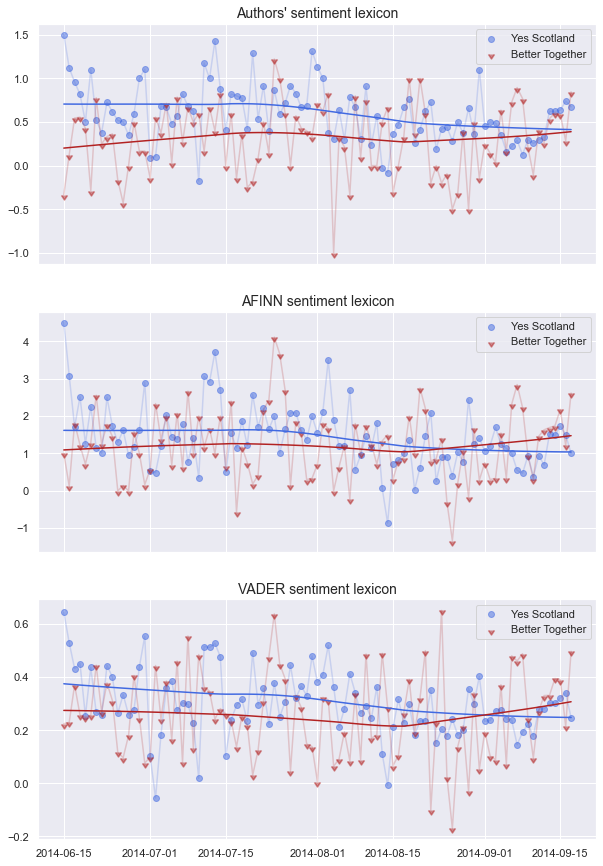